In [1]:
# Import Libraries
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from ta.others import daily_return,cumulative_return
from plotly.offline import init_notebook_mode
import cufflinks as cf
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import os
import requests
from bs4 import BeautifulSoup
import warnings
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline
init_notebook_mode(connected=True)
cf.go_offline()

In [2]:
# Check if folder input exists

# Define the folder name
folder_name = '../input'

# Check if the folder exists
if not os.path.exists(folder_name):
    # If it doesn't exist, create the folder
    os.makedirs(folder_name)
    print(f"'{folder_name}' folder created.")
else:
    print(f"'{folder_name}' folder already exists.")


'../input' folder already exists.


In [3]:
# Webscrapping Wikipedia table to get the SP500 components
page = requests.get("https://en.wikipedia.org/wiki/List_of_traded_commodities")
soup = BeautifulSoup(page.text, 'html.parser') 
table = soup.find_all(class_="wikitable sortable")[6]
table1 = soup.find_all(class_="wikitable sortable")[3]

In [4]:
# Convert html table to dataframe
table = pd.read_html(str(table))
table1 = pd.read_html(str(table1))
wiki = pd.concat([table[0],table1[0]])
wiki.head(40)

,Commodity,Contract size,Currency,Main exchange,Symbol
0,Gold,100 troy ounces,USD ($),COMEX,GC
1,Platinum,50 troy ounces,USD ($),NYMEX,PL
2,Palladium,100 troy ounces,USD ($),NYMEX,PA
3,Silver,"5,000 troy ounces",USD ($),COMEX,SI
0,WTI Crude Oil,"1000 bbl (42,000 U.S. gal)",NaN,"NYMEX, ICE","CL (NYMEX), WTI (ICE)"
1,Brent Crude,"1000 bbl (42,000 U.S. gal)",NaN,ICE,B
2,Ethanol,"29,000 U.S. gal",NaN,CBOT,AC (Open Auction) ZE (Electronic)
3,Natural gas,"10,000 million BTU",NaN,NYMEX,NG
4,Natural gas,"1,000 therms",NaN,ICE,NBP
5,Heating Oil,"1000 bbl (42,000 U.S. gal)",NaN,NYMEX,HO


In [5]:
wiki = wiki[wiki['Symbol'].isin(['GC','PL','PA','SI','NG','B'])]
wiki['Symbol'][wiki['Symbol'] == 'B'] = 'BZ'
wiki['Symbol'] = wiki['Symbol'].apply(lambda x: x + '=F')
wiki

,Commodity,Contract size,Currency,Main exchange,Symbol
0,Gold,100 troy ounces,USD ($),COMEX,GC=F
1,Platinum,50 troy ounces,USD ($),NYMEX,PL=F
2,Palladium,100 troy ounces,USD ($),NYMEX,PA=F
3,Silver,"5,000 troy ounces",USD ($),COMEX,SI=F
1,Brent Crude,"1000 bbl (42,000 U.S. gal)",NaN,ICE,BZ=F
3,Natural gas,"10,000 million BTU",NaN,NYMEX,NG=F


In [6]:
# Add ETF
wiki.loc[6]=['Invesco Physical Gold ETC','Euro(€)','Euro(€)','MI','SGLD.MI']
wiki = wiki.reset_index(drop=True)
wiki

,Commodity,Contract size,Currency,Main exchange,Symbol
0,Gold,100 troy ounces,USD ($),COMEX,GC=F
1,Platinum,50 troy ounces,USD ($),NYMEX,PL=F
2,Palladium,100 troy ounces,USD ($),NYMEX,PA=F
3,Silver,"5,000 troy ounces",USD ($),COMEX,SI=F
4,Brent Crude,"1000 bbl (42,000 U.S. gal)",NaN,ICE,BZ=F
5,Natural gas,"10,000 million BTU",NaN,NYMEX,NG=F
6,Invesco Physical Gold ETC,Euro(€),Euro(€),MI,SGLD.MI


In [7]:
# Get the data for the stock
index_list = wiki['Symbol'].tolist()

In [8]:
# Save all the historical data
for stock in tqdm(index_list):
    data = yf.download(stock, progress=False)
    data.to_csv(f"../input/{stock}.csv",index=True)

  0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
# Configuration of different parameters of the notebook
ticker = 'GC=F'
year = '2024'

In [10]:
# Check DataFrame
stock_ticker = pd.read_csv(f"../input/{ticker}.csv",index_col="Date",parse_dates=True)
stock_ticker.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0
2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0
2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0
2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2
2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0
2000-09-07,274.000000,274.000000,274.000000,274.000000,274.000000,125
2000-09-08,273.299988,273.299988,273.299988,273.299988,273.299988,0
2000-09-11,273.100006,273.100006,273.100006,273.100006,273.100006,0
2000-09-12,272.899994,272.899994,272.899994,272.899994,272.899994,0


In [11]:
# Check DataFrame tail
stock_ticker.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-09,2491.300049,2504.699951,2491.300049,2501.800049,2501.800049,96
2024-09-10,2512.300049,2512.300049,2512.300049,2512.300049,2512.300049,5
2024-09-11,2525.800049,2525.800049,2502.300049,2512.100098,2512.100098,90
2024-09-12,2529.100098,2557.000000,2523.399902,2551.199951,2551.199951,132
2024-09-13,2568.800049,2581.800049,2565.000000,2581.300049,2581.300049,31
2024-09-16,2580.399902,2580.399902,2580.399902,2580.399902,2580.399902,28
2024-09-17,2581.199951,2581.800049,2564.300049,2564.300049,2564.300049,22
2024-09-18,2570.699951,2570.699951,2549.199951,2570.699951,2570.699951,25
2024-09-19,2566.000000,2588.000000,2566.000000,2588.000000,2588.000000,99


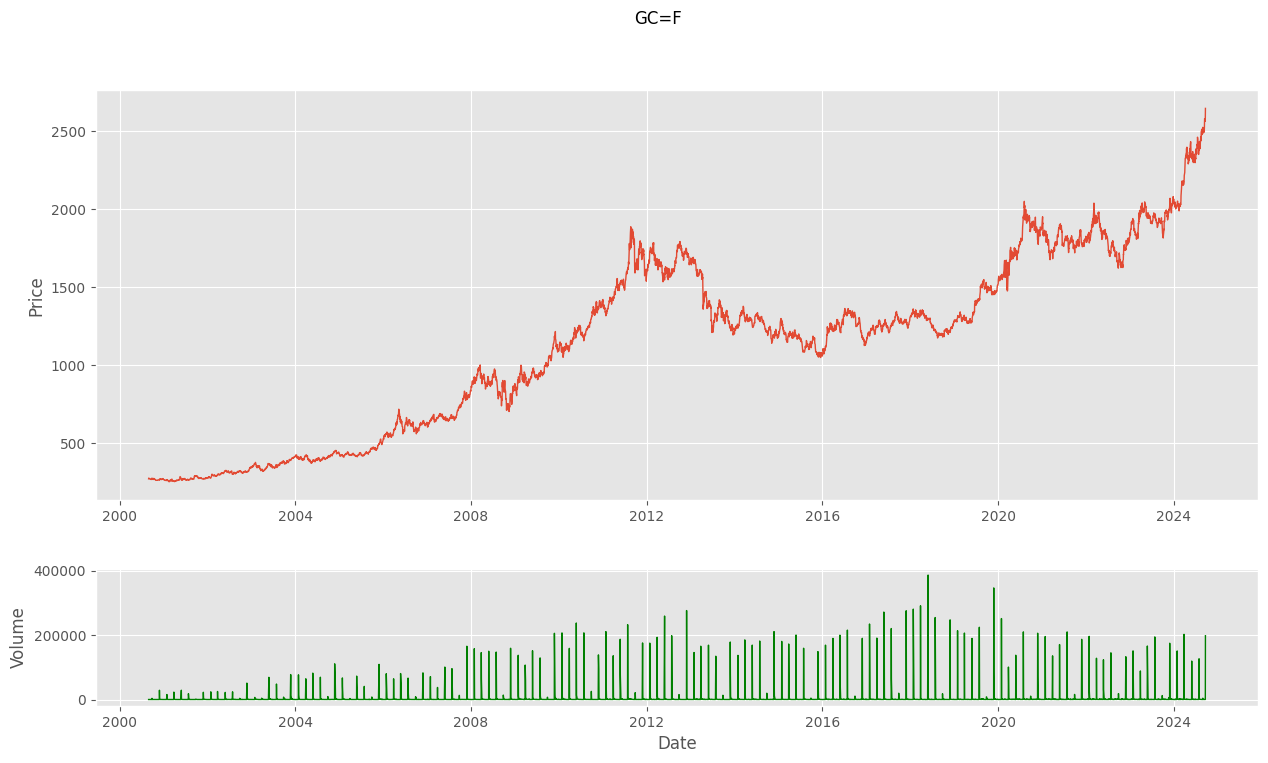

In [12]:
# Plot the adjusted close price
plt.style.use('ggplot')
fig, axs = plt.subplots(2,1,gridspec_kw={'height_ratios': [3,1],'hspace':0.25},figsize=(15, 8),sharex=True)

fig.suptitle(f"{ticker}")
axs[0].set_ylabel('Price')
axs[0].plot(stock_ticker['Adj Close'],linewidth=1)
axs[0].tick_params(labelbottom=True)

axs[1].set_ylabel("Volume")
axs[1].set_xlabel("Date")
axs[1].plot(stock_ticker['Volume'],linewidth=1,color='g')

plt.show()

In [13]:
fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01,specs=[[{'rowspan':3,'colspan':1}],[None],[None],[{'rowspan':1,'colspan':1}]])

# Graph (1,1)
fig.add_trace(go.Scatter(x=stock_ticker.index,y=stock_ticker['Adj Close'],mode="lines",name=f"{ticker}"),row=1, col=1)
# Update xaxis properties
fig.update_yaxes(title_text="Price", row=1, col=1)

# Graph (4,1)
fig.add_trace(go.Scatter(x=stock_ticker.index,y=stock_ticker['Volume'],mode="lines",name='Volume'),row=4, col=1)
fig.update_yaxes(title_text="Volume", row=4, col=1)

fig.update_layout(height=800, width=1300,showlegend=False,title=f"{ticker}")

fig.show()

In [14]:
# Group per year and calculate cummulative return
stock_ticker['Year'] = stock_ticker.index.year
annual_data = stock_ticker.groupby('Year').agg(Adj_Close=('Adj Close','last'))
annual_data['Return'] = annual_data["Adj_Close"].pct_change()*100
annual_data

,Adj_Close,Return
Year,,
2000,272.000000,NaN
2001,278.700012,2.463240
2002,347.600006,24.721920
2003,415.700012,19.591486
2004,437.500000,5.244163
2005,517.099976,18.194280
2006,635.200012,22.838917
2007,834.900024,31.438918
2008,883.599976,5.833028


In [15]:
# Plotly
fig = make_subplots()

# Add colors
colors = ['green' if x >= 0 else 'red' for x in annual_data['Return']]

# Graph (1,1)
fig.add_trace(go.Bar(y=annual_data['Return'],x=annual_data['Return'].index,text=round(annual_data['Return'],2),textposition='outside',marker_color=colors,hoverinfo='skip'),row=1,col=1)

# Update xaxis properties
fig.update_yaxes(title_text="Returns", row=1, col=1)

fig.update_layout(xaxis=dict(tickvals=annual_data.index,tickangle=-45),height=800, width=1300,title=f"Returns per year {ticker}")

fig.show()

In [16]:
# Add Technical Analysis Indicators

# Modified Moving Average 20
stock_ticker['MMA20'] = stock_ticker['Adj Close'].loc[year].rolling(20).mean() #Adj Close 20 MA

# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=stock_ticker["Adj Close"].loc[year], window=20, window_dev=2)

# Bollinger Bands
stock_ticker['BB_Upper'] = indicator_bb.bollinger_hband()
stock_ticker['BB_Lower'] = indicator_bb.bollinger_lband()

# Initialize RSI Indicator
indicator_rsi = RSIIndicator(close=stock_ticker["Adj Close"].loc[year], window=14)

# RSI
stock_ticker['RSI'] = indicator_rsi.rsi()

# Daily Return
stock_ticker['Daily_Return'] = daily_return(stock_ticker["Adj Close"].loc[year])

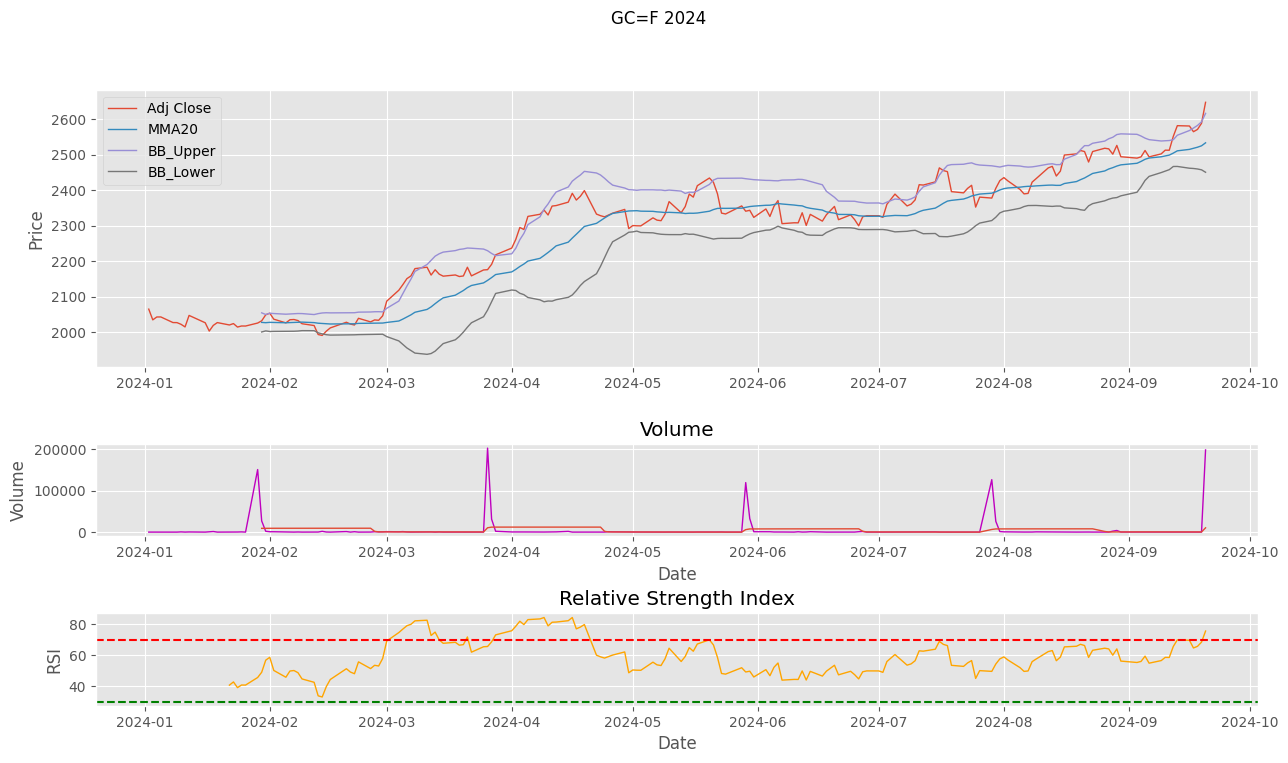

In [17]:
# Plot the adjusted close price
fig, axs = plt.subplots(3,1,gridspec_kw={'height_ratios': [3,1,1],'hspace':0.5},figsize=(15, 8),sharex=True)

# Graph 0
fig.suptitle(f"{ticker} {year}")
axs[0].set_ylabel('Price')
axs[0].plot(stock_ticker['Adj Close'].loc[year],linewidth=1)
axs[0].plot(stock_ticker['MMA20'],linewidth=1) 
axs[0].plot(stock_ticker['BB_Upper'],linewidth=1)
axs[0].plot(stock_ticker['BB_Lower'],linewidth=1)
axs[0].legend(['Adj Close','MMA20','BB_Upper','BB_Lower'])
axs[0].tick_params(labelbottom=True)

# Graph 1
axs[1].set_ylabel("Volume")
axs[1].set_xlabel("Date")
axs[1].set_title('Volume')
axs[1].plot(stock_ticker['Volume'].loc[year],linewidth=1,color='m')
axs[1].plot(stock_ticker['Volume'].loc[year].rolling(20).mean(),linewidth=1) #Volume 20 MMA
axs[1].tick_params(labelbottom=True)

# Graph 2
axs[2].set_title('Relative Strength Index')
axs[2].set_ylabel("RSI")
axs[2].set_xlabel("Date")
axs[2].plot(stock_ticker['RSI'],color='orange',linewidth=1)
# Add two horizontal lines, signalling the buy and sell ranges.
# Oversold
axs[2].axhline(30, linestyle='--', linewidth=1.5, color='green')
# Overbought
axs[2].axhline(70, linestyle='--', linewidth=1.5, color='red')

plt.show()

In [18]:
# Plot the adjusted close price
fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01,specs=[[{'rowspan':2,'colspan':1}],[None],[{'rowspan':1,'colspan':1}],[{'rowspan':1,'colspan':1}]])

# Graph (1,1)
fig.add_trace(go.Scatter(x=stock_ticker['Adj Close'].loc[year].index,y=stock_ticker['Adj Close'].loc[year],mode="lines",name=f'{ticker}'),row=1,col=1)
fig.add_trace(go.Scatter(x=stock_ticker['BB_Lower'].loc[year].index,y=stock_ticker['BB_Lower'].loc[year],mode="lines",name='BB_Lower'),row=1,col=1)
fig.add_trace(go.Scatter(x=stock_ticker['BB_Upper'].loc[year].index,y=stock_ticker['BB_Upper'].loc[year],mode="lines",name='BB_Upper'),row=1,col=1)
fig.add_trace(go.Scatter(x=stock_ticker['MMA20'].loc[year].index,y=stock_ticker['MMA20'].loc[year],mode="lines",name='MMA20'),row=1,col=1)
# Update xaxis properties
fig.update_yaxes(title_text="Price", row=1, col=1)

# Graph (3,1)
fig.add_trace(go.Scatter(x=stock_ticker['Volume'].loc[year].index,y=stock_ticker['Volume'].loc[year],mode="lines",name='Volume'),row=3, col=1)
fig.add_trace(go.Scatter(x=stock_ticker['Volume'].loc[year].index,y=stock_ticker['Volume'].loc[year].rolling(20).mean(),mode="lines",name='MMA20'),row=3,col=1)
fig.update_yaxes(title_text="Volume", row=3, col=1)

# Graph (4,1)
fig.add_trace(go.Scatter(x=stock_ticker['RSI'].loc[year].index,y=stock_ticker['RSI'].loc[year],mode="lines",name='RSI'),row=4, col=1)
fig.add_hline(y=30, line_width=1, line_dash="dash", line_color="green",row=4,col=1)
fig.add_hline(y=70, line_width=1, line_dash="dash", line_color="red",row=4,col=1)
fig.update_yaxes(title_text="RSI", row=4, col=1)

fig.update_layout(height=800, width=1300,showlegend=False,title=f"{ticker} {year}")

fig.show()

In [19]:
stock_ticker.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Year,MMA20,BB_Upper,BB_Lower,RSI,Daily_Return
Date,,,,,,,,,,,,
2024-09-09,2491.300049,2504.699951,2491.300049,2501.800049,2501.800049,96,2024,2493.659973,2538.157552,2449.162394,56.441400,0.332867
2024-09-10,2512.300049,2512.300049,2512.300049,2512.300049,2512.300049,5,2024,2496.154980,2538.923969,2453.385992,58.522789,0.419698
2024-09-11,2525.800049,2525.800049,2502.300049,2512.100098,2512.100098,90,2024,2498.424988,2539.484752,2457.365224,58.465496,-0.007959
2024-09-12,2529.100098,2557.000000,2523.399902,2551.199951,2551.199951,132,2024,2504.014990,2541.713252,2466.316729,65.564745,1.556461
2024-09-13,2568.800049,2581.800049,2565.000000,2581.300049,2581.300049,31,2024,2510.424988,2554.390172,2466.459803,69.838708,1.179841
2024-09-16,2580.399902,2580.399902,2580.399902,2580.399902,2580.399902,28,2024,2514.514978,2567.593764,2461.436192,69.560659,-0.034872
2024-09-17,2581.199951,2581.800049,2564.300049,2564.300049,2564.300049,22,2024,2517.639978,2574.575659,2460.704297,64.606239,-0.623929
2024-09-18,2570.699951,2570.699951,2549.199951,2570.699951,2570.699951,25,2024,2520.609973,2581.940402,2459.279544,65.653483,0.249577
2024-09-19,2566.000000,2588.000000,2566.000000,2588.000000,2588.000000,99,2024,2524.589978,2592.240002,2456.939954,68.377305,0.672970


  0%|          | 0/7 [00:00<?, ?it/s]

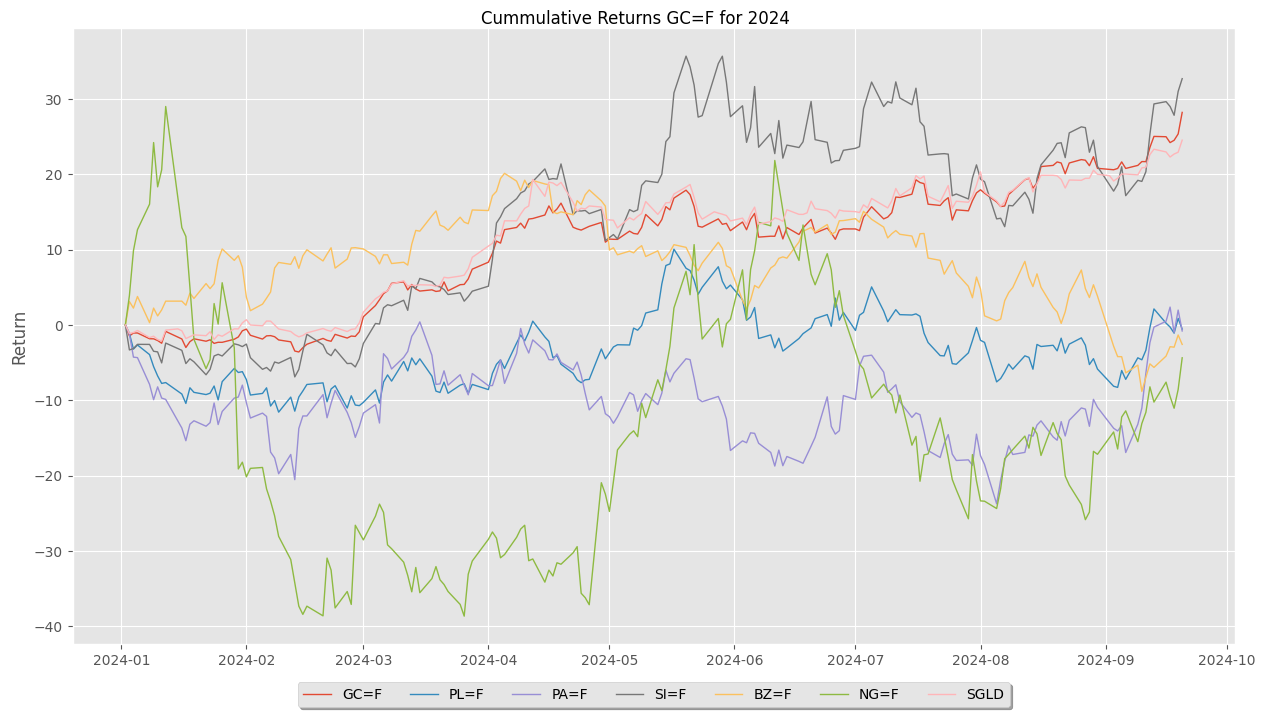

In [20]:
# Plot Cummulative Returns
fig, axs = plt.subplots(figsize=(15, 8))

# Graph
fig.suptitle(f"Cummulative Returns {ticker} for {year}")
axs.set_ylabel('Return')
labels = []

# Loop all stock files and get cummulative return for year
for stock in tqdm(index_list):
    f = os.path.join("../input", stock)
    df = pd.read_csv(f+".csv",index_col="Date",parse_dates=True)
    df['Cummulative_Return'] = cumulative_return(df["Adj Close"].loc[year])
    axs.plot(df['Cummulative_Return'].loc[year],linewidth=1)
    labels.append(stock.split('.')[0])

# Shrink current axis's height by 10% on the bottom
box = axs.get_position()
axs.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height])

# Put a legend below current axis
axs.legend(labels, loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=10)

plt.show()

In [21]:
# Plotly
fig = make_subplots()

# Graph (1,1)
# Loop all stock files and get cummulative return for year
for stock in tqdm(index_list):
    f = os.path.join("../input", stock)
    df = pd.read_csv(f+".csv",index_col="Date",parse_dates=True)
    df['Cummulative_Return'] = cumulative_return(df["Adj Close"].loc[year])
    fig.add_trace(go.Scatter(x=df['Cummulative_Return'].loc[year].index,y=df['Cummulative_Return'].loc[year],mode="lines",name=stock.split('.')[0]),row=1,col=1)

# Update xaxis properties
fig.update_yaxes(title_text="Return", row=1, col=1)

fig.update_layout(height=800, width=1300,showlegend=True,title=f"Cummulative Returns {ticker} for {year}")

fig.show()

  0%|          | 0/7 [00:00<?, ?it/s]

In [22]:
# Create also table of cummulative returns
list = []

for stock in tqdm(index_list):
    f = os.path.join("../input",stock)
    df = pd.read_csv(f+".csv",index_col="Date",parse_dates=True)
    df['Cummulative_Return'] = cumulative_return(df["Adj Close"].loc[year])
    list.append([df.loc[year].tail(1).index.item(),stock.split('.csv')[0],df["Cummulative_Return"].loc[year].iloc[-1]])


cum = pd.DataFrame(list, columns=['Date','Symbol','Cummulative_Return'])
cum = wiki[['Symbol','Commodity']].merge(cum,on='Symbol')
cum.sort_values(by=['Cummulative_Return'],ignore_index=True, ascending=False)

  0%|          | 0/7 [00:00<?, ?it/s]

,Symbol,Commodity,Date,Cummulative_Return
0,SI=F,Silver,2024-09-20,32.705520
1,GC=F,Gold,2024-09-20,28.226130
2,SGLD.MI,Invesco Physical Gold ETC,2024-09-20,24.543761
3,PL=F,Platinum,2024-09-20,-0.547948
4,PA=F,Palladium,2024-09-20,-0.796958
5,BZ=F,Brent Crude,2024-09-20,-2.582684
6,NG=F,Natural gas,2024-09-20,-4.361370
